In [1]:
%pip install langchain_teddynote langchain-community pyngrok fuzzywuzzy python-dotenv langchain langchain-experimental langchain-openai langgraph pymongo pydantic pandas pillow faiss-cpu rank-bm25 matplotlib streamlit ipython pymupdf pypdf

Note: you may need to restart the kernel to use updated packages.


In [108]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Aiffelthon/chul/aiffelthon_tys_imdg/tys')

import os
os.chdir('/content/drive/MyDrive/Aiffelthon/chul/aiffelthon_tys_imdg/tys/baseline/app')
os.chdir('/content/drive/MyDrive/Aiffelthon/chul/aiffelthon_tys_imdg/tys/baseline/app/H1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Graph

## setting

In [3]:
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI

# .env 파일에서 환경 변수 로드
load_dotenv()

True

In [4]:
import re

def str2dict_parser(input_str, type_name):
    """
    주어진 문자열에서 responce와 동적인 키 이름의 데이터를 파싱하여 딕셔너리로 반환하는 함수
    """
    # 정규 표현식으로 키 이름과 값을 동적으로 파싱
    pattern = rf"responce: (\d), {type_name}: (.*)"
    match = re.match(pattern, input_str)

    if match:
        responce = int(match.group(1))  # responce 값을 정수로 변환
        dynamic_list = match.group(2).split(", ")  # 리스트로 변환
        result = {"responce": responce, type_name: dynamic_list}
        return result
    else:
        raise ValueError("Input string does not match the expected format.")



## Create vector Content

In [6]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
import os
import json

def create_vector_db():
    # Path to save vector DB
    vector_store_path = "./resources/vector/index"

    # Skip creation if vector DB already exists
    if os.path.exists(vector_store_path):
        print("Vector DB already exists. Skipping creation.")
        return

    # Load PDF file
    loader = PyPDFLoader("./resources/docs/IMDG_격리규정안내서.pdf")
    documents = loader.load()

    # Text splitting settings
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=200,
        chunk_overlap=50,
        length_function=len,
        is_separator_regex=False,
    )

    # Split document into chunks
    chunks = text_splitter.split_documents(documents)

    # Initialize OpenAI embeddings
    embeddings = OpenAIEmbeddings()

    # Create FAISS vector DB
    vectorstore = FAISS.from_documents(chunks, embeddings)

    # Save vector DB
    os.makedirs(os.path.dirname(vector_store_path), exist_ok=True)
    vectorstore.save_local(vector_store_path)

    print(f"Vector DB created and saved to {vector_store_path}")


def load_faiss_vector():
    # Initialize OpenAI embeddings
    embeddings = OpenAIEmbeddings()

    # Update path to the newly created vector DB location
    vector_store_path = "./resources/vector/index"
    vectorstore = FAISS.load_local(
        vector_store_path,
        embeddings,
        allow_dangerous_deserialization=True
    )

    return vectorstore.as_retriever()

def load_segregation_table():
    """Load segregation table from JSON file"""
    try:
        with open("./resources/docs/imdg_격리표.json", "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading segregation table: {e}")
        return None


def load_container_segregation_table():
    """Load container segregation requirements from JSON file"""
    try:
        with open("./resources/docs/imdg_컨테이너적재격리표.json", "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading container segregation table: {e}")
        return None


create_vector_db()
retriever = load_faiss_vector()

segregation_table = load_segregation_table()
container_segregation = load_container_segregation_table()

Vector DB already exists. Skipping creation.


## STEP Context and Condition


In [7]:
Context_prompt = PromptTemplate.from_template("""
You are an IMDG Code expert with 20 years of experience in maritime dangerous goods regulations.
Answer the question based on the following context and segregation information.

Reference Materials:
1. IMDG Code Context:
{context}

2. Segregation Information:
- Segregation Table: {segregation_table}
- Container Segregation Requirements: {container_segregation}

Question:
{user_input}

## Response Guidelines:
1. Provide a comprehensive yet concise response in Korean
2. Base all answers strictly on IMDG Code references
3. When necessary, refer to Reference Materials #2 (Segregation Information) including Segregation Table and Container Segregation Requirements
4. Use clear markdown formatting
5. Cite specific sections and pages
6. Highlight critical information in **bold**

## Response Structure:
### 💡 Key Points
[Provide a clear, direct answer to the question]

### 📚 References
- Document: [filename.pdf]
- Section: [relevant sections]
- Page: [page numbers]

Remember: If the answer is not found in the context or segregation tables, please write "I don't know...🥲"
"""
)

In [8]:
user_input = '위험물은 왜 격리해야되는지?'
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
Context_chain = Context_prompt | llm
Context_input = {
          "context": retriever,  # Document 객체 리스트 그대로 전달
          "user_input": user_input,
          "segregation_table": lambda _: json.dumps(segregation_table, ensure_ascii=False) if segregation_table else "No segregation information available",
          "container_segregation": lambda _: json.dumps(container_segregation, ensure_ascii=False) if container_segregation else "No container segregation information available"
      }
response = Context_chain.invoke(Context_input)
response.content

/var/folders/qm/s09l6qvs1nx4fx83gly57t4c0000gn/T/ipykernel_3221/3145802675.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


'### 💡 Key Points\n위험물은 **화재, 폭발, 화학 반응** 등으로 인한 사고를 예방하기 위해 격리해야 합니다. 격리는 서로 다른 위험물 간의 상호작용을 방지하고, 사고 발생 시 피해를 최소화하는 데 중요한 역할을 합니다. IMDG 코드에서는 위험물의 종류에 따라 적절한 격리 기준을 설정하고 있으며, 이는 안전한 운송을 보장하기 위한 필수적인 조치입니다.\n\n### 📚 References\n- Document: IMDG Code\n- Section: Segregation Requirements\n- Page: 관련 페이지는 IMDG 코드에서 확인 필요 (구체적인 페이지 번호는 제공되지 않음)'

In [9]:
def Context_node0(state):
  print('Context_node running')
  user_input = state['user_input']
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
  Context_chain = Context_prompt | llm
  Context_input = {
            "context": retriever,  # Document 객체 리스트 그대로 전달
            "user_input": user_input,
            "segregation_table": lambda _: json.dumps(segregation_table, ensure_ascii=False) if segregation_table else "No segregation information available",
            "container_segregation": lambda _: json.dumps(container_segregation, ensure_ascii=False) if container_segregation else "No container segregation information available"
        }
  response = Context_chain.invoke(Context_input)
  result = response.content
  print('Context_node running end')
  return {'Context_result' : result}

In [10]:
def Both_situ(state):
  token = state['token']
  if 0 in token :
    Ans = 'Both'
    return 'Both'
  else :
    return 'Context'

## Step -1 . Domain Check Node

답변을 할수있는지 Chunk를 찾아보기
RAG 사용해야함

답변을 할수있다 없다를 판단해서 다음 노드를 활성화 시킴
condtioal edge로 사용

In [11]:
Domain_check_prompt = PromptTemplate.from_template("""
당신은 다음 질문 {user_input}에 답변이 가능한지를 판단하는 전문가입니다.
다음 Context :{context}
내에서 답변을 할수있는 질문이라면 yes를 아니라면 no로 대답해주세요

다음과 같은 질문들은 답변이 가능합니다

Logic : UN number 또는 class를 제공해주며 격리 방법 또는 세부 격리요건에 대해 물어봅니다.

Context : Logic 질문을 제외한 간단한 질의 응답입니다. Context 규정집안에있는 정보를 통해 이를 답할수있습니다

Both : 두가지 모두를 물어보는 질문입니다. 격리의 질문과 격리질문을 제외한 질문이 두가지 모두있을때 선택해주세요

결과는 아래 형식으로 작성해주세요:
yes or no
"""
)

In [12]:
user_input = '111Un number 1234와 3323 , 3232 3가지 품목의 격리방법을 알고싶어4342'
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
Domain_check_chain = Domain_check_prompt | llm
Domain_check_input = {"context": retriever, "user_input" : user_input}
response = Domain_check_chain.invoke(Domain_check_input)
response.content

'no'

In [13]:
def setting_node(state):
  print('setting running')
  token = []
  Context_result = 'empty'
  segre_method_result = 'empty'
  Contain_Segre_result = 'empty'
  return {'token' : token, 'Context_result' : Context_result, 'segre_method_result' : segre_method_result, 'Contain_Segre_result' : Contain_Segre_result}

In [14]:
def node0(state):
  print('node0 running')
  token = []
  user_input = state['user_input']
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
  Domain_check_chain = Domain_check_prompt | llm
  Domain_check_input = {"context": retriever, "user_input" : user_input}
  response = Domain_check_chain.invoke(Domain_check_input)
  result = response.content
  print ('result = ',result)

  # 임시방편 코드
  result = 'yes'
  return result

In [15]:
def node0_result(state):
  Ans = 'i dont know'
  return Ans

## Step 0 Content Segre Detect

이 질문이 Context 질문인지, Segre인지 둘다인지
3지선다를 진행함

이에 따라서 다음 3가지 분기로 나뉘어짐

In [16]:
CS_Detect_prompt = PromptTemplate.from_template("""
당신은 다음 질문 {user_input}에 대해 어떤 질문 유형인지 판단하는 전문가입니다.
답은 3가지중 하나입니다.

Logic : UN number 또는 class를 제공해주며 격리 방법 또는 세부 격리요건에 대해 물어봅니다.

Context : Logic 질문을 제외한 간단한 질의 응답입니다. 규정집안에있는 정보를 통해 이를 답할수있습니다

Both : 두가지 모두를 물어보는 질문입니다. 격리의 질문과 격리질문을 제외한 질문이 두가지 모두있을때 선택해주세요

결과는 아래 형식으로 작성해주세요:
Logic or Context or Both(str 형식으로 답변)
"""
)

In [17]:
user_input = '111Un number 1234와 3323 , 3232 3가지 품목의 격리방법을 알고싶어4342'
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
class_detect_chain = CS_Detect_prompt | llm
class_detect_input = {"user_input": user_input}
response = class_detect_chain.invoke(class_detect_input)
response.content

'Logic'

In [21]:
def CS_Detect0(state):
  print('CS_Detect node running')
  user_input = state['user_input']
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
  cs_detect_chain = CS_Detect_prompt | llm
  cs_detect_input = {"user_input": user_input}
  response = cs_detect_chain.invoke(cs_detect_input)
  result = response.content
  print('CS_ result =',result)
  if result == 'Both':
    tokens = state['token'] + [0]
    return {'token' : tokens , 'CS_result' : result}
  else :
    print('run?')
    return {'CS_result' : result}

In [22]:
# conditional edge 분기용 함수
def CS_Detect(state):
  print('CS_Detect edge running')
  CS_result = state['CS_result']
  print(CS_result)
  return CS_result

## Step1. UN number detection node

In [23]:
UN_detect_prompt = PromptTemplate.from_template("""
당신은 다음 질문 {user_input}에 대해  UN 번호가 포함되어있는지를 판단하는 전문가입니다.
당신의 지식은 UN 번호의 판정만으로 제한됩니다

UN number는 0부터 4000사이의 정수이며 보통 0002과 같이 4자리로 표현됩니다.
가끔 앞의 0이 생략될수도있습니다.

4자리 숫자라고 모두 UN number가 아니니 문맥에 주의하시기바랍니다

다음 조건을 충족해야 답변 가능합니다:
1. 질문 내에 UN 번호가 포함되어 있어야 합니다.
2. UN 번호가 2개 이상 존재하는지 확인해야 합니다.

결과는 아래 형식으로 작성해주세요:
- responce: 1 (포함) 또는 0 (미포함)
- numbers: 1111,1222 (UN number를 반환)

예시:
responce: 1, numbers: 1235, 4534
responce: 0, numbers: (빈칸)

""")

In [24]:
user_input = '1111 Un number 1234와 3323  2가지 품목의 격리방법을 알고싶어4342'
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
class_detect_chain = UN_detect_prompt | llm
class_detect_input = {"user_input": user_input}
response = class_detect_chain.invoke(class_detect_input)
content0 = response.content
result = str2dict_parser(content0, 'numbers')
result['numbers']

['1111', '1234', '3323']

In [25]:
def UN_detect(state):
  user_input = state['user_input']
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
  UN_detect_chain = UN_detect_prompt | llm
  UN_detect_input = {"user_input": user_input}
  response = UN_detect_chain.invoke(UN_detect_input)
  content0 = response.content
  result = str2dict_parser(content0, 'numbers')
  bool_result = result['responce']
  unnumbers = result['numbers']
  print('UN run', unnumbers)
  if bool_result == 0:
      pass
  else :
      return {"token": state["token"] + [1], "unnumbers" : unnumbers}


이제 이걸 받아와서
- responce가 1이면 token에 1을 추가
- token과 UN number state를 업데이트

## Step 2 [Node1] classer node

DG_LIST 에 UN number 입력해서 class 받아오기


In [26]:
from ai.demo import DG_LIST

Checking for index at: /content/drive/MyDrive/Aiffelthon/chul/aiffelthon_tys_imdg/tys/baseline/app/resources/vector_sample/index/index.faiss
Vector store found: /content/drive/MyDrive/Aiffelthon/chul/aiffelthon_tys_imdg/tys/baseline/app/resources/vector_sample/index/index.faiss
Loading existing vector store from /content/drive/MyDrive/Aiffelthon/chul/aiffelthon_tys_imdg/tys/baseline/app/resources/vector_sample/index/index.faiss
Vector store loaded successfully.


In [27]:
un_numbers = ['1234', '2000']  # 입력 리스트

# 모든 결과를 담을 리스트
class_results = []

# DG_LIST에서 데이터 가져오기
dg_items = DG_LIST.get_all_un_no()
dg_options = [(f"{item['unNumber']} - {item['psn']}", item["unNumber"]) for item in dg_items]
dg_labels = [label for label, _ in dg_options]

# 각 un_number에 대해 처리
for un_number in un_numbers:
    # 해당 un_number와 일치하는 데이터 찾기
    oid = next(item for item in dg_items if item["unNumber"] == un_number)["id"]
    item = DG_LIST.find_one(oid)
    # 클래스 결과 추가
    class_results.append(item['class'])

print(class_results)

['3', '4.1']


In [28]:
def get_class_results(numbers):
    """
    입력: numbers (list[str]) - UN 번호 리스트
    출력: class_results (list[str]) - 각 UN 번호의 클래스 결과 리스트
    """
    # 모든 결과를 담을 리스트
    class_results = []

    # DG_LIST에서 데이터 가져오기
    dg_items = DG_LIST.get_all_un_no()

    # 각 un_number에 대해 처리
    for un_number in numbers:
        try:
            # 해당 un_number와 일치하는 데이터 찾기
            oid = next(item for item in dg_items if item["unNumber"] == un_number)["id"]
            item = DG_LIST.find_one(oid)
            # 클래스 결과 추가
            class_results.append(item['class'])
        except StopIteration:
            # un_number가 dg_items에 없는 경우 처리
            print(f"Warning: UN number {un_number} not found.")
            class_results.append(None)  # 없는 경우 None 추가

    return class_results

In [29]:
def node1(state):
  print('node1 running')
  token_1 = state["token"]
  if 1 in token_1:
    unnumbers = state["unnumbers"]
    result = get_class_results(unnumbers)
    print('node1 is working')
    return {'class_list' : result}
  else :
    pass


UN number를 받은 node는 class값을 반환

class state를 업데이트

## Step 3 class detect node

In [30]:
class_detect_prompt = PromptTemplate.from_template("""
당신은 다음 질문 {user_input}에 대해  품목에 대한 class가 포함되어있는지를 판단하는 전문가입니다.
당신의 지식은 class 존재의 판정만으로 제한됩니다

클래스는 1.1 부터 9까지로 이루어져있습니다.
소수점은 1자리를 넘지 않습니다.
예시 1.1 , 1.2, 1.3, 3.1, 4.1, 5.1  등
1.1a와 같이 1번대 class는 뒤에 영단어 하나가 같이올수있습니다.

다음 조건을 충족해야 답변 가능합니다:
1. 질문 내에 class 번호가 포함되어 있어야 합니다.
2. class가 2개 이상 존재하는지 확인해야 합니다.

결과는 아래 형식으로 작성해주세요:
- responce: 1 (포함) 또는 0 (미포함)
- class_list : 1.1a, 4.1 (class를 반환)

예시:
responce: 1, class_list: 1.1d, 4.1
responce: 0, class_list: (빈칸)

""")

In [31]:
user_input = '위험물 UNunmber 1123와 2000의 격리 방법을 알려줘'
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
class_detect_chain = class_detect_prompt | llm
class_detect_input = {"user_input": user_input}
response = class_detect_chain.invoke(class_detect_input)
print(response.content)
result = str2dict_parser(response.content, 'class_list')
bool_result = result['responce']
class_list = result['class_list']
class_list

responce: 0, class_list: 


['']

In [32]:
def class_Detect(state):
  print('class_Detect running')
  user_input = state['user_input']
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
  class_detect_chain = class_detect_prompt | llm
  class_detect_input = {"user_input": user_input}
  response = class_detect_chain.invoke(class_detect_input)
  content0 = response.content
  result = str2dict_parser(content0, 'class_list')
  bool_result = result['responce']
  class_list = result['class_list']
  if bool_result == 0:
      pass
  else :
      return {"class_list" : class_list}

여기서는 이제
답변한 부분에 대해서

responce가 1이라면
class state만 업데이트

responce가 0이라면 다음으로 넘어가기

## STEP 4 Segre detection

In [33]:
segre_detect_prompt = PromptTemplate.from_template("""
당신은 다음 질문 {user_input}에 대해  격리 방법을 요청하고있는지를 판단하는 전문가입니다.
당신의 지식은 격리방법 요청의 판정만으로 제한됩니다

격리 방법을 요청하는 예시는 다음과 같습니다.
격리방법을 직설적으로 요청함
두개의 품목을 같은 컨테이너에 적재가 가능한지 질문함
등의 상황이있습니다.
질문을 보고 격리방법을 요청하는지를 판단해주세요

결과는 아래 형식으로 작성해주세요:
responce: 1 (요청함) 또는 0 (요청안함)
why : 격리 단어때문에 요청했다고 판단함

예시:
responce: 1, why: 같은 컨테이너에 품목을 넣는것에 대한 질문임
responce: 0, why: 없음

""")

In [34]:
user_input = '111a1 Class 1.1a와 3.1 2가지 품목의 격리방법을 알고싶어 각각 밀폐형과 개방형이고 수직으로 쌓으려해'
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
class_detect_chain = segre_detect_prompt | llm
class_detect_input = {"user_input": user_input}
response = class_detect_chain.invoke(class_detect_input)
content0 = response.content
print(content0)
result = str2dict_parser(content0, 'why')
bool_result = result['responce']

responce: 1, why: 두 품목의 격리 방법을 요청하고 있으며, 밀폐형과 개방형의 차이를 언급하고 있기 때문임.


In [35]:
def segre_Detect(state):
  print('segre_Detect running')
  user_input = state['user_input']
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
  segre_detect_chain = segre_detect_prompt | llm
  segre_detect_input = {"user_input": user_input}
  response = segre_detect_chain.invoke(segre_detect_input)
  content0 = response.content
  result = str2dict_parser(content0, 'why')
  bool_result = result['responce']
  if bool_result == 0:
      pass
  else :
      return {"token": state["token"] + [2]}

여기서는

responce가 1이라면
token에 2를 추가함

token state를 반환

## Step 5 [Node2] segre_method

In [36]:
from segre_search import segre_matrix, get_segregation_value


In [37]:
get_segregation_value(segre_matrix, ['1.1a','None'], ['3','None'])

'4'

In [38]:
segregation_descriptions = {
    "1": {"name": "분리적재 (Away from)", "details": ["최소 3m 이상의 수평거리 유지", "갑판상부/하부 적재 가능", "동일 구획에 적재 가능하나 물리적 분리 필요"]},
    "2": {"name": "격리적재 (Separated from)", "details": ["서로 다른 격실이나 화물창에 적재", "갑판상부 적재 시 최소 6m 이상 수평거리 유지", "수직방향 격리 시 수밀 격벽 필요"]},
    "3": {"name": "1구획실 또는 1화물창 격리적재", "details": ["최소 1개의 완전한 구획실이나 화물창으로 분리", "수평방향으로 최소 12m 이상 거리 유지", "수직방향 격리 불가"]},
    "4": {"name": "1구획실 또는 1화물창 종방향 격리적재", "details": ["최소 24m의 수평거리 유지", "중간에 완전한 구획실이나 화물창 필요", "가장 엄격한 격리 요건"]},
    "X": {"name": "특정 격리규정 확인", "details": ["특정 격리규정을 확인하기 위하여 위험물 목록(DGL)을 참고할 것"]},
    "*": {"name": "제1급 물질 간 격리규정", "details": ["제1급 물질 상호 간의 격리규정에 관하여 제7.2.7.1항을 참조할 것", " 선적 계획 시 제1급 물질의 경우 등급 정보만으로는 부족", "혼적 그룹 정보를 확인하여 계획 수립 필요", "필요시 위험물 전문가의 자문을 구하는 것이 안전"]},
}


In [39]:
segregation_descriptions.get('1')

{'name': '분리적재 (Away from)',
 'details': ['최소 3m 이상의 수평거리 유지', '갑판상부/하부 적재 가능', '동일 구획에 적재 가능하나 물리적 분리 필요']}

In [40]:
def node2(state):
  print('node2 running')
  token_2 = state["token"]

  if 2 in token_2:
    class_list = state["class_list"]
    print('node2 is working')
    print(class_list[0])
    print(class_list[1])
    class_input1 = [class_list[0],'None']
    class_input2 = [class_list[1],'None']
    segre_method_num = get_segregation_value(segre_matrix, class_input1, class_input2)
    Node2_result = segregation_descriptions.get(segre_method_num)
    # state - 정수 형태로 method number 저장
    return {'segre_method_result' : Node2_result, 'segre_method_num' : segre_method_num}
  else :
    pass

input : class state 2개

output : segre method 반환

**graph**
segre_method_result state 업데이트

## Step 6 Cont_detection

이부분의 성능이 애매함
위에서 답변한 segre method를 입력값으로 받아야겠다

성능이 잘안나오는구만 이부분이

In [41]:
Cont_detect_prompt = PromptTemplate.from_template("""
당신은 다음 질문 {user_input}에 대해 컨테이너의 옵션에 따른 세부 격리요건을 필요로하는지를 판단하는 전문가입니다.
당신의 지식은세부 격리요건 답변의 필요성의 판정만으로 제한됩니다

유저의 질문이 다음 답변 : {segre_method_result} 이 답변으로 충분하지 않고 세부 격리 요건을 원한다면 판정을 해야합니다

세부 격리요건은 간단한 격리요건을 요구하는것이 아닌
2개의 컨테이너의 상태에 따른 세부 격리요건을 요구하는 질문이 들어올수있습니다.

밀폐형 또는 개방형 컨테이너에 대한 세부요건
컨테이너를 수직 또는 수평으로 적재할때의 세부요건
컨테이너를 갑판 상부 또는 하부에 적재할때의 세부요건
등에 대해서 물어볼수있습니다.

결과는 아래 형식으로 작성해주세요:
- responce: 1 (요청함) 또는 0 (요청안함)
- Why : 컨테이너의 조건을 상세히 요청했기에 세부요건을 원한다고 판단함

예시:
responce: 1, why: 밀페형 컨테이너에 품목을 넣는것에 대한 질문임
responce: 0, why: 없음

""")

In [42]:
user_input = '111a1 Class 1.1a와 3.1 , 4.3 3가지 품목의 격리방법을 알고싶어 434d2'
segre_method_result = '격리방법 4번 이 격리방법은 가장 엄격한 격리 방법이며 최고등급의 격리를 요구함'

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
class_detect_chain = Cont_detect_prompt | llm
class_detect_input = {"user_input": user_input, 'segre_method_result' : segre_method_result}
response = class_detect_chain.invoke(class_detect_input)
response.content

'responce: 1, why: 컨테이너의 상태에 따른 세부 격리요건을 요구했기에 세부요건을 원한다고 판단함'

In [43]:
def Cont_Detect(state):
  print('Cont_Detect running')
  user_input = state['user_input']
  segre_method_result = state['segre_method_result']
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
  Cont_detect_chain = Cont_detect_prompt | llm
  Cont_detect_input = {"user_input": user_input, 'segre_method_result' : segre_method_result}
  response = Cont_detect_chain.invoke(Cont_detect_input)
  content0 = response.content
  result = str2dict_parser(content0, 'why')
  bool_result = result['responce']
  if bool_result == 0:
      pass
  else :
      return {"token": state["token"] + [3]}

## Step 7 Cont_Opt detection

input : token

token = 3일때 코드가 돌아감

output = 3가지 옵션에 대한 답

In [79]:
Cont_Opt_detect_prompt = PromptTemplate.from_template("""
당신은 다음 질문 {user_input}에 대해  컨테이너 옵션이 포함되어있는지를 판단하는 전문가입니다.
당신의 지식은 컨테이너 옵션의 판정만으로 제한됩니다

컨테이너 옵션은 다음과 같이 3개에 대해서 판단합니다.
만약 옵션을 말하지 않았다면 ALL을 선택하면됩니다
컨테이너 조건을 받지않았다면 ALL로 반환해주세요
filter_type : "All", "Vertical(수직)", "Horizontal(수평)"
deck_position : "All", "onDeck(갑판 상부)", "underDeck(갑판 하부)"

타입은 4가지중에서 하나를 선택해야합니다.
closed = 밀폐형, open = 개방형
두가지를 탐색후 4가지 조건중 하나를 골라야합니다
segregation_filter : "All", "closedToClosed", "closedToOpen", "openToOpen"
closedToClosed = 밀폐형에 밀폐형
closedToOpen = 밀폐형과 개방형
openToOpen = 개방형과 개방형


결과는 아래 형식으로 작성해주세요:
ex1)
segregation_filter = 'All'
filter_type = 'All'
deck_position = 'All'

ex2)
segregation_filter = 'closedToClosed'
filter_type = 'All'
deck_position = 'onDeck'

ex3)
segregation_filter = 'closedToOpen'
filter_type = 'Vertical'
deck_position = 'underDeck'


""")

In [83]:
user_input = '111a1 Class 1.1a와 3.1 2가지 품목의 격리방법을 알고싶어 각각 밀폐형과 개방형이고 수직으로 쌓으려해'
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
class_detect_chain = Cont_Opt_detect_prompt | llm
class_detect_input = {"user_input": user_input}
response = class_detect_chain.invoke(class_detect_input)
response.content

"segregation_filter = 'closedToOpen'  \nfilter_type = 'Vertical'  \ndeck_position = 'All'  "

In [86]:
parsed = parse_variables(response.content)
segregation_filter = parsed["segregation_filter"]
filter_type = parsed["filter_type"]
deck_position = parsed["deck_position"]

print(segregation_filter)
print(filter_type)
print(deck_position)

closedToOpen
Vertical
All


In [87]:
def Cont_Opt_detect(state):
  print('Cont_Opt_detect running')
  token_3 = state["token"]
  if 3 in token_3:
    user_input = state['user_input']
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    Cont_Opt_detect_chain = Cont_Opt_detect_prompt | llm
    Cont_Opt_detect_input = {"user_input": user_input, 'segre_method_result' : segre_method_result}
    response = Cont_Opt_detect_chain.invoke(Cont_Opt_detect_input)
    content0 = response.content
    # result = str2dict_parser(content0, 'why')
    # bool_result = result['responce']

    Cont_Opt = content0
    return {'Cont_Opt' : Cont_Opt}
  else :
    pass

여기서 받은 컨테이너 옵션

Cont_Opt state를 업데이트

## Step 8 [Node3] Contain_Segre

In [18]:
def load_container_segregation_matrix():
    try:
        with open("./resources/docs/imdg_컨테이너적재격리표.json", "r", encoding="utf-8") as f:
            return json.load(f)["segregationMatrix"]
    except Exception as e:
        print(f"Error loading container segregation matrix: {e}")
        return None

segregation_matrix = load_container_segregation_matrix()

In [19]:
for requirement in segregation_matrix["requirements"]:
  if requirement['segregationCode'] == 1:
    print(requirement)

{'segregationType': '분리적재', 'segregationCode': 1, 'vertical': {'closedToClosed': {'allowance': '하나 위에 다른 하나 허용'}, 'closedToOpen': {'allowance': '밀폐형 위에 개방형 허용'}, 'openToOpen': {'allowance': '갑판에 의하여 격리되지 아니하는 한, 동일 수직선상 금지'}}, 'horizontal': {'onDeck': {'closedToClosed': {'fore_aft': '제한 없음', 'athwartships': '제한 없음'}, 'closedToOpen': {'fore_aft': '제한 없음', 'athwartships': '제한 없음'}, 'openToOpen': {'fore_aft': '1컨테이너 구역', 'athwartships': '1컨테이너 구역'}}, 'underDeck': {'closedToClosed': {'fore_aft': '제한 없음', 'athwartships': '제한 없음'}, 'closedToOpen': {'fore_aft': '제한 없음', 'athwartships': '제한 없음'}, 'openToOpen': {'fore_aft': '1컨테이너 구역 또는 1격벽', 'athwartships': '1컨테이너 구역'}}}}


In [ ]:
segregation_matrix["requirements"]

In [20]:
segregation_code = '4'
segregation_filter = 'closedToOpen'
filter_type = 'All'
deck_position = 'All'

In [21]:
def Cont_result_fnc(segregation_code, segregation_filter,filter_type, deck_position):
  report = ''
  if segregation_matrix:
    report += "### 격리 요건:\n"
    for requirement in segregation_matrix["requirements"]:
        if str(requirement["segregationCode"]) == segregation_code:
            # 수직 요건 출력 (Vertical)
            if filter_type in ["All", "Vertical"]:
                report += "#### 수직 요건 (Vertical)\n"
                vertical = requirement.get("vertical", {})
                for key, value in vertical.items():
                    if segregation_filter == "All" or key == segregation_filter:
                        report += f"- {key}: {value['allowance']}\n"

            # 수평 요건 출력 (Horizontal)
            if filter_type in ["All", "Horizontal"]:
                report += "\n#### 수평 요건 (Horizontal)\n"
                horizontal = requirement.get("horizontal", {})
                for deck_key, deck_value in horizontal.items():
                    # deck_position 필터 적용
                    if deck_position == "All" or deck_key == deck_position:
                        report += f"##### {deck_key}:\n"
                        for pair_key, pair_value in deck_value.items():
                            if segregation_filter == "All" or pair_key == segregation_filter:
                                report += f"- {pair_key}:\n"
                                if isinstance(pair_value, dict):
                                    for sub_key, sub_value in pair_value.items():
                                        if isinstance(sub_value, dict) and 'content' in sub_value:
                                            report += f"  - {sub_key}: {sub_value['content']}\n"
                                            if 'footnote' in sub_value:
                                                report += f"    - 주석: {sub_value['footnote']}\n"
                                        else:
                                            report += f"  - {sub_key}: {sub_value}\n"
                                else:
                                    report += f"  - {pair_value}\n"
            report += "\n"
  return report

Cont_result_fnc(segregation_code, segregation_filter,filter_type, deck_position)

'### 격리 요건:\n#### 수직 요건 (Vertical)\n- closedToOpen: 금지\n\n#### 수평 요건 (Horizontal)\n##### onDeck:\n- closedToOpen:\n  - fore_aft: 24m의 최소 수평거리\n  - athwartships: 금지\n##### underDeck:\n- closedToOpen:\n  - fore_aft: 2격벽\n  - athwartships: 금지\n\n'

In [91]:
def parse_variables(input_string):
    """
    주어진 문자열을 파싱하여 변수로 반환
    """
    variables = {}
    lines = input_string.strip().split("\n")
    for line in lines:
        key, value = line.split("=", 1)
        variables[key.strip()] = value.strip().strip("'")
    return variables



input token , Segre Method, Cont_Opt 을 받음

Contain_Segre_result state 업데이트

In [98]:
def node3(state):
  print('node3 running')
  token_3 = state["token"]
  # Segre_method
  if 3 in token_3:
    # 받아오기
    Cont_Opt = state["Cont_Opt"]
    segre_method_num = state["segre_method_num"]

    if segre_method_num == 'X' or segre_method_num == '*':
      Node3_result = 'empty'
    else :
      segre_method_num = int(segre_method_num)
      # 파싱해서 각 변수에 할당
      parsed = parse_variables(Cont_Opt)
      segregation_filter = parsed["segregation_filter"]
      filter_type = parsed["filter_type"]
      deck_position = parsed["deck_position"]
      Node3_result = Cont_result_fnc(segre_method_num, segregation_filter,filter_type, deck_position)
    print('node3 is working')
    return {'Contain_Segre_result' : Node3_result}
  else :
    pass

## final_node

In [48]:
final_prompt = PromptTemplate.from_template("""
당신은 다음 질문 {user_input}에대해 답변을 해야합니다

다음 content 만을 활용해서 답변해주세요

{Context_result}
{segre_method_result}
{Contain_Segre_result}

답변은 위 content에 있는 내용을 바탕으로만 진행해야합니다.

질문의 내용과 무관하거나 content 외의 답변을 하지마세요

""")

In [49]:
def final_node(state):
  user_input = state['user_input']
  Context_result = state['Context_result']
  segre_method_result = state['segre_method_result']
  Contain_Segre_result = state['Contain_Segre_result']

  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
  final_chain = final_prompt | llm
  final_input = {
            "user_input": user_input,
            "Context_result": Context_result,
            "segre_method_result": segre_method_result,
            "Contain_Segre_result": Contain_Segre_result

        }
  response = final_chain.invoke(final_input)
  result = response.content
  return {'final_result' : result}

## Concat Graph

In [99]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

## state 정의
class MyState(TypedDict):
    user_input: str
    Context_result : str
    CS_result : str
    token : list[int]
    unnumbers : list[str]
    class_list : list[str]
    segre_method_num : str
    segre_method_result : str
    Cont_Opt : str
    Contain_Segre_result : str
    graph_log : list[str]
    final_result : str
    domain_result : str


## 그래프 생성
graph = StateGraph(MyState)

## 노드 추가
graph.add_node("setting_node", setting_node)
graph.add_node("Context_node0", Context_node0)
graph.add_node("node0_result", node0_result)
graph.add_node("CS_Detect0", CS_Detect0)
graph.add_node("CS_Detect", CS_Detect)
graph.add_node("UN_detect", UN_detect)
graph.add_node("node1", node1)
graph.add_node("class_Detect", class_Detect)
graph.add_node("segre_Detect", segre_Detect)
graph.add_node("node2", node2)
graph.add_node("Cont_Detect", Cont_Detect)
graph.add_node("Cont_Opt_detect", Cont_Opt_detect)
graph.add_node("node3", node3)
graph.add_node("final_node", final_node)

## 엣지 추가
graph.add_edge(START, "setting_node")

graph.add_conditional_edges(
    'setting_node',
    node0,
    {
        "yes": "CS_Detect0",
        "no": 'final_node'
    }
)

graph.add_conditional_edges(
    "CS_Detect0",
    CS_Detect,
    {
        "Context": "Context_node0",
        "Logic": "UN_detect",
        "Both": "Context_node0",
        "default": END
    }
)

graph.add_conditional_edges(
    "Context_node0",
    Both_situ,
    {
        "Both": "UN_detect",
        "Context": 'final_node'
    }
)

graph.add_edge('UN_detect', "node1")
graph.add_edge('node1', "class_Detect")
graph.add_edge('class_Detect', "segre_Detect")
graph.add_edge('segre_Detect', "node2")
graph.add_edge('node2', "Cont_Detect")
graph.add_edge('Cont_Detect', "Cont_Opt_detect")
graph.add_edge('Cont_Opt_detect', "node3")
graph.add_edge('node3', 'final_node')
graph.add_edge('final_node', END)
graph = graph.compile()


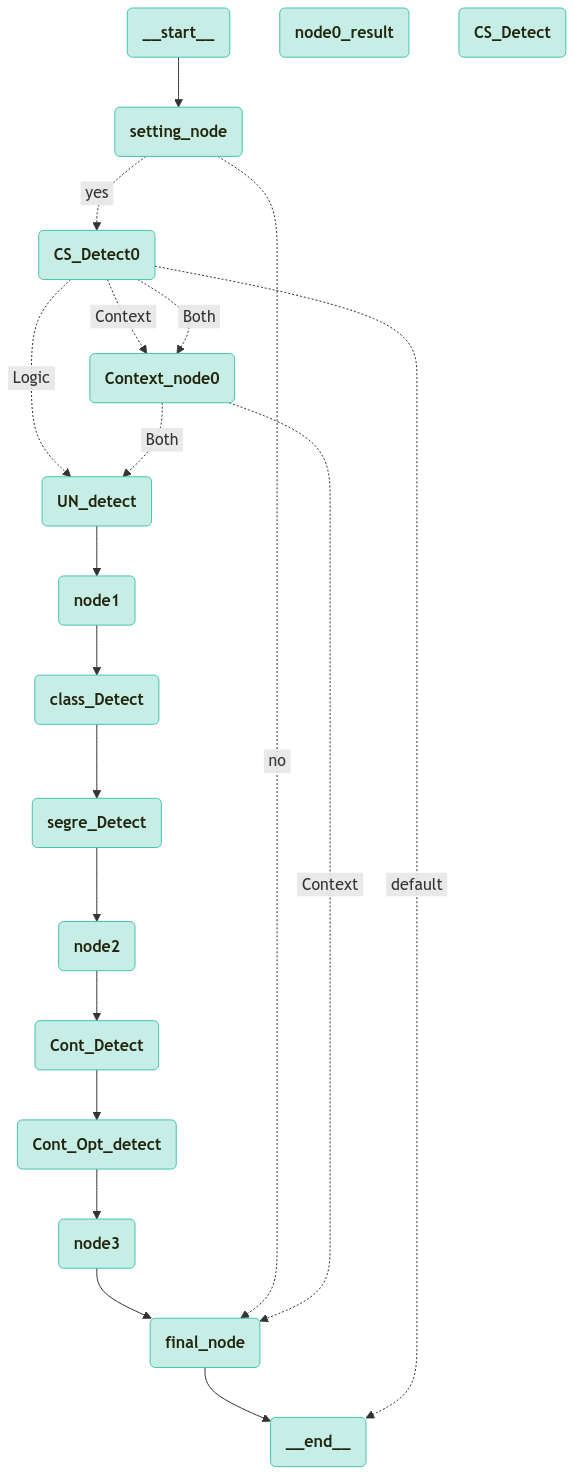

In [51]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

## run graph

In [103]:
graph.invoke({'user_input' : '위험물 격리의 필요성에 대해서 말해줘'})

setting running
node0 running
result =  yes
CS_Detect node running
CS_ result = Context
run?
CS_Detect edge running
Context
Context_node running
Context_node running end


{'user_input': '위험물 격리의 필요성에 대해서 말해줘',
 'Context_result': '### 💡 Key Points\n위험물 격리는 해상 운송 중 안전을 보장하기 위해 필수적입니다. 위험물은 서로 다른 성질을 가지고 있으며, 이로 인해 특정 물질들이 함께 저장될 경우 화재, 폭발, 화학 반응 등의 위험이 증가할 수 있습니다. IMDG 코드에서는 이러한 위험을 최소화하기 위해 **격리 요구사항**을 명시하고 있습니다. 예를 들어, 서로 반응할 수 있는 물질들은 반드시 분리하여 저장해야 하며, 이는 사고 발생 시 피해를 줄이는 데 중요한 역할을 합니다.\n\n### 📚 References\n- Document: IMDG Code\n- Section: Segregation Requirements\n- Page: [해당 페이지 번호는 제공되지 않았습니다]',
 'CS_result': 'Context',
 'token': [],
 'segre_method_result': 'empty',
 'Contain_Segre_result': 'empty',
 'final_result': '위험물 격리는 해상 운송 중 안전을 보장하기 위해 필수적입니다. 위험물은 서로 다른 성질을 가지고 있으며, 이로 인해 특정 물질들이 함께 저장될 경우 화재, 폭발, 화학 반응 등의 위험이 증가할 수 있습니다. IMDG 코드에서는 이러한 위험을 최소화하기 위해 격리 요구사항을 명시하고 있습니다. 예를 들어, 서로 반응할 수 있는 물질들은 반드시 분리하여 저장해야 하며, 이는 사고 발생 시 피해를 줄이는 데 중요한 역할을 합니다.'}

In [104]:
graph.invoke({'user_input' : '위험물 UNunmber 1123와 2000의 격리 방법을 알려줘'})

setting running
node0 running
result =  yes
CS_Detect node running
CS_ result = Both
CS_Detect edge running
Both
Context_node running
Context_node running end
UN run ['1123', '2000']
node1 running
node1 is working
class_Detect running
segre_Detect running
node2 running
node2 is working
3
4.1
Cont_Detect running
Cont_Opt_detect running
node3 running
node3 is working


{'user_input': '위험물 UNunmber 1123와 2000의 격리 방법을 알려줘',
 'Context_result': '### 💡 Key Points\n위험물 UN번호 1123(아세톤)와 UN번호 2000(가연성 가스)의 격리 방법은 다음과 같습니다:\n\n- **UN 1123 (아세톤)**: 이 물질은 **가연성**이며, 다른 가연성 물질과의 격리는 필수입니다. 아세톤은 산화제와의 격리도 필요합니다.\n- **UN 2000 (가연성 가스)**: 이 물질은 **가연성**이며, 산화제 및 산성 물질과의 격리가 필요합니다.\n\n따라서, 두 물질은 서로 **격리**되어야 하며, 특히 **가연성 물질**과의 접촉을 피해야 합니다. \n\n### 📚 References\n- Document: IMDG Code\n- Section: Segregation Table\n- Page: 해당 페이지는 IMDG Code에서 확인 필요\n\n위의 정보는 IMDG Code의 격리 요구 사항에 기반하여 제공되었습니다.',
 'CS_result': 'Both',
 'token': [0, 1, 2, 3],
 'unnumbers': ['1123', '2000'],
 'class_list': ['3', '4.1'],
 'segre_method_num': 'X',
 'segre_method_result': {'name': '특정 격리규정 확인',
  'details': ['특정 격리규정을 확인하기 위하여 위험물 목록(DGL)을 참고할 것']},
 'Cont_Opt': "segregation_filter = 'All'  \nfilter_type = 'All'  \ndeck_position = 'All'  ",
 'Contain_Segre_result': 'empty',
 'final_result': '위험물 UN번호 1123(아세톤)와 UN번호 2000(가연성 가스)의 격리 방법은 다음과 같습니다:\n\n- **UN 1123 (아세톤)**: 이 물질은 **가연성**이며, 다른 가연

In [100]:
graph.invoke({'user_input' : '111a1 Class 1.1a와 3 2가지 품목의 격리방법을 알고싶어 closed to open이고 수직으로 쌓으려해'})

setting running
node0 running
result =  no
CS_Detect node running
CS_ result = Logic
run?
CS_Detect edge running
Logic
UN run ['(빈칸)']
node1 running
class_Detect running
segre_Detect running
node2 running
node2 is working
1.1a
3
Cont_Detect running
Cont_Opt_detect running
node3 running
node3 is working


{'user_input': '111a1 Class 1.1a와 3 2가지 품목의 격리방법을 알고싶어 closed to open이고 수직으로 쌓으려해',
 'Context_result': 'empty',
 'CS_result': 'Logic',
 'token': [2, 3],
 'class_list': ['1.1a', '3'],
 'segre_method_num': '4',
 'segre_method_result': {'name': '1구획실 또는 1화물창 종방향 격리적재',
  'details': ['최소 24m의 수평거리 유지', '중간에 완전한 구획실이나 화물창 필요', '가장 엄격한 격리 요건']},
 'Cont_Opt': "segregation_filter = 'closedToOpen'  \nfilter_type = 'Vertical'  \ndeck_position = 'All'  ",
 'Contain_Segre_result': '### 격리 요건:\n#### 수직 요건 (Vertical)\n- closedToOpen: 개방형 대 개방형과 동일\n\n',
 'final_result': '1구획실 또는 1화물창 종방향 격리적재의 경우, closed to open 방식으로 수직으로 쌓을 때는 다음과 같은 격리 요건을 준수해야 합니다:\n\n- 최소 24m의 수평거리를 유지해야 합니다.\n- 중간에 완전한 구획실이나 화물창이 필요합니다.\n- 가장 엄격한 격리 요건이 적용됩니다.\n\n수직 요건에 대해서는 closedToOpen 방식이 개방형 대 개방형과 동일하다는 점을 유의해야 합니다.'}

# 연습장

## 격리표 제작

In [ ]:
!python segre_search.py

Segregation value for 1.1 and 1.2: *


In [ ]:
from segre_search import segre_matrix, get_segregation_value

# Example usage
class1 = ['1.4G', None]
class2 = ['9', None]

# Retrieve the segregation value
result = get_segregation_value(segre_matrix, class1, class2)

# Output the result
print(type(result)) # '*', '4', 'X'
print(f"격리방법은 : {result}")

<class 'str'>
격리방법은 : X


In [ ]:
!python test_graph2.py

Traceback (most recent call last):
  File "/content/drive/MyDrive/Aiffelthon/chul/aiffelthon_tys_imdg/tys/baseline/app/test_graph2.py", line 78, in <module>
    state = graph.run_node("decide", initial_state)
AttributeError: 'StateGraph' object has no attribute 'run_node'. Did you mean: 'add_node'?


## Class 추출 문제

In [ ]:
from ai.demo import DG_LIST

Checking for index at: /content/drive/MyDrive/Aiffelthon/chul/aiffelthon_tys_imdg/tys/baseline/app/resources/vector_sample/index/index.faiss
Vector store found: /content/drive/MyDrive/Aiffelthon/chul/aiffelthon_tys_imdg/tys/baseline/app/resources/vector_sample/index/index.faiss
Loading existing vector store from /content/drive/MyDrive/Aiffelthon/chul/aiffelthon_tys_imdg/tys/baseline/app/resources/vector_sample/index/index.faiss
Vector store loaded successfully.


In [ ]:
# 이미 UNnumber와 품목명만 가지고 오게 전처리가 되어있다
dg_items = DG_LIST.get_all_un_no()
# 옵션은
dg_options = [(f"{item['unNumber']} - {item['psn']}", item["unNumber"]) for item in dg_items]
dg_labels = [label for label, _ in dg_options]

In [ ]:
selected_label = dg_labels[1]

In [ ]:
un_number_1 = (value for label, value in dg_options if selected_label == label)
un_number_1

<generator object <genexpr> at 0x7d72126f3530>

In [ ]:
un_number_1 = next(value for label, value in dg_options if selected_label == label)
un_number_1

'0005'

In [ ]:
oid_0 = next(item for item in dg_items if item["unNumber"] == un_number_1)
oid_0

{'id': '677b874ffecea5f2b07dc5ec',
 'unNumber': '0005',
 'psn': '병기용 완성탄(작약이 들어있는 것)'}

In [ ]:
oid_1 = next(item for item in dg_items if item["unNumber"] == un_number_1)["id"]
oid_1

'677b874ffecea5f2b07dc5ec'

In [ ]:
item_1 = DG_LIST.find_one(oid_1)
item_1

{'unNumber': '0005',
 'properShippingName': {'ko': '병기용 완성탄(작약이 들어있는 것)',
  'en': 'CARTRIDGES FOR WEAPONS with bursting charge'},
 'class': '1.1F',
 'subsidiaryRisk': None,
 'packingGroup': None,
 'specialProvisions': None,
 'limitedQuantities': '0',
 'exceptedQuantities': 'E0',
 'packing': {'instruction': 'P130\nLP101', 'provisions': None},
 'ibc': {'instruction': None, 'provisions': None},
 'portableTanks': {'instruction': None, 'provisions': None},
 'ems': {'fire': 'F-B', 'spillage': 'S-X'},
 'stowageHandling': '적재방법 03.\nSW1',
 'segregation': None,
 'propertiesCautions': '부록 B의 용어 해설을 참조할 것.'}

In [ ]:
good1_class = []

In [ ]:
good1_class.append(item_1['class'])
good1_class.append(item_1.get('subsidiaryRisk', '-'))

In [ ]:
good1_class

['1.1F', None]

In [ ]:
item_1['class']

'1.1F'

In [ ]:
print(item_1['subsidiaryRisk'])

None


In [ ]:
print(item_1.get('subsidiaryRisk', '-'))

None


## stream lit 사용

In [ ]:
!ngrok config add-authtoken 2ZqtCc5YdpVlQ8L4xTsEUfhCmtt_dqaC9SPiqCt2MjDGhYJx

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
import threading
import os

# ngrok을 사용해 터널링 설정
public_url = ngrok.connect(8502)
print(f"Public URL: {public_url}")

# Streamlit 실행 함수 정의
def run_streamlit():
    os.system("streamlit run demo_test.py")

# Streamlit을 별도 스레드에서 실행
thread = threading.Thread(target=run_streamlit)
thread.start()

Public URL: NgrokTunnel: "https://4e9d-35-185-78-94.ngrok-free.app" -> "http://localhost:8502"


In [ ]:
import sys
print(sys.path)

print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/drive/MyDrive/Aiffelthon/chul/aiffelthon_tys_imdg/tys']
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/drive/MyDrive/Aiffelthon/chul/aiffelthon_tys_imdg/tys', '/content/drive/MyDrive/Aiffelthon/chul/aiffelthon_tys_imdg/tys']


# Graph 연습장

## Lang Graph 연습장

In [ ]:
from dotenv import load_dotenv
from langchain.chat_models import ChatOpenAI

# .env 파일에서 환경 변수 로드
load_dotenv()

# GPT-4o-mini 설정
gpt4o_mini = ChatOpenAI(
    model_name="gpt-4o-mini",  # GPT-4o-mini에 해당하는 모델명
    temperature=0.7,
    max_tokens=150,
)

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

# 그래프의 상태를 정의하는 클래스
class MyState(TypedDict):
    counter: int

# StateGraph 인스턴스 생성
graph = StateGraph(MyState)

# 카운터를 증가시키는 노드 함수 정의
def increment(state):
    return {"counter": state["counter"] + 1}

# 'increment' 노드 추가
graph.add_node("increment", increment)

# START에서 'increment' 노드로 엣지 추가
graph.add_edge(START, "increment")

# 'increment' 노드에서 END로 엣지 추가
graph.add_edge("increment", END)

# 그래프 컴파일
app = graph.compile()

# 그래프 실행
result = app.invoke({"counter": 0})
print(result)

{'counter': 1}


In [ ]:
from langchain.schema import HumanMessage

# GPT-4o-mini 사용
response_mini = gpt4o_mini.invoke([HumanMessage(content="Hello, how are you?")])
print(response_mini.content)

Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


In [ ]:
response = gpt4o_mini.invoke(["Hello, how are you?"])
response.content

"Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?"

In [ ]:
from langchain_core.prompts import PromptTemplate

In [ ]:
from langchain_core.prompts import PromptTemplate

class_detect_prompt = PromptTemplate.from_template("""
당신은 다음 질문 {user_input}에 대해 격리 질문, 일반 질문이 포함되어있는지 판단하는 전문가입니다.

답변은 항상3가지로 나뉩니다. 일반질문, 격리질문,

N number는 0부터 4000사이의 정수이며 보통 0002과 같이 4자리로 표현됩니다.
가끔 앞의 0이 생략될수도있습니다.

다음 조건을 충족해야 답변 가능합니다:
1. 질문 내에 UN 번호가 포함되어 있어야 합니다.
2. UN 번호가 2개 이상 존재하는지 확인해야 합니다.

결과는 아래 형식으로 작성해주세요:
- responce: 1 (포함) 또는 0 (미포함)
- why: 포함된 이유를 간결히 설명

예시:
- responce: 1, why: UN number라고 말한뒤 뒤에 4자리 숫자가 2개 이상 존재함 1235, 4534
- responce: 0, why: UN 번호가 없습니다.

""")

In [ ]:
from langchain.output_parsers import PydanticOutputParser

class CaseMethod(BaseModel):
    pick_tools: list[int] = Field(description="필요하다고 생각되는 툴 번호를 리스트형태로 반환")
    pick_reason: str = Field(description="각 선택한 툴에 대한 선택 이유를 간단하게 반환")

parser = PydanticOutputParser(pydantic_object=CaseMethod)

case_prompt = PromptTemplate.from_template("""
다음 들어오는 {user_input} 값을 읽고 다음 질문에 답변하세요
1. 다음 질문이 몇번 도구를 이용해서 답변할수있는지 판단하세요 도구는 총 1,2,3이있습니다
2. 도구는 한가지 이상선택해야하며 2개 이상을 선택 가능합니다
3. 선택한 도구를 list형태로 반환해주세요 예시 [1,3]
4. 선택한 이유를 3줄이내로 간단하게 return해주세요

반드시 다음 형식으로 반환하세요:

{{
    "pick_tools": [도구 번호를 리스트 형태로 기입],
    "pick_reason": "선택 이유를 간단히 설명"
}}

""")

In [ ]:
user_input = '1번과 2번을 사용한 문제'

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
# case_method_llm = llm.with_structured_output(CaseMethod)
case_method_chain = case_prompt | llm | parser
case_method_input = {"user_input": user_input}
response = case_method_chain.invoke(user_input)
response
# print(response.content)

CaseMethod(pick_tools=[1, 2], pick_reason='1번 도구는 문제 값을 읽는 데 필요한 기본 정보를 제공하고, 2번 도구는 추가적인 세부사항을 분석하는 데 유용합니다. 두 도구를 함께 사용하면 보다 정확하고 포괄적인 답변을 도출할 수 있습니다.')

In [ ]:
user_input = [HumanMessage(content="Hello, how are you?")]


llm = ChatOpenAI(model="gpt-4o", temperature=0)
case_method_llm = llm.with_structured_output(CaseMethod)
case_method_chain = case_prompt | case_method_llm
case_method_input = {"user_input": user_input}
result: CaseMethod = case_method_chain.invoke(user_input)

NotImplementedError: 

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import Annotated, Any, List, TypedDict
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from langchain.chat_models import ChatOpenAI
from langchain_core.prompts import PromptTemplate

# .env 파일에서 환경 변수 로드
load_dotenv()

class MyState2(TypedDict):
    user_input: str
    counter: int
    case0: List[int]
    result_node1 : list[str]
    result_node2 : list[str]
    result_node3 : list[str]

class CaseMethod(BaseModel):
    pick_tools: str = Field(description="필요하다고 생각되는 툴 번호를 리스트형태로 반환")
    pick_reason: str = Field(description="각 선택한 툴에 대한 선택 이유를 2줄이내로 반환")

case_prompt = PromptTemplate.from_template("""
다음 들어오는 {user_input} 값을 읽고 다음 질문에 답변하세요
1. 다음 질문이 몇번 도구를 이용해서 답변할수있는지 판단하세요 도구는 총 1,2,3이있습니다
2. 도구는 한가지 이상선택해야하며 2개 이상을 선택 가능합니다
3. 선택한 도구를 list형태로 반환해주세요 예시 [1,3]
4. 선택한 이유를 3줄이내로 간단하게 return해주세요

# user input :
{user_input}

Answer :

""")

def hc_choice_case0(state):
    user_input = state['user_input']
    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    case_method_llm = llm.with_structured_output(CaseMethod)
    case_method_chain = case_prompt | case_method_llm
    case_method_input = {"user_input": user_input}
    result: CaseMethod = case_method_chain.invoke(user_input)
    pick_tools = result.pick_tools
    print(result.pick_reason)
    return {"case0": pick_tools}

def hc_add_case(state):
    return{'case0' : state['case0']+[1, 3]}

def node1(state):
    state['result_node1'].append('node1_result')
    print('node1 is run')
    return {"result_node1": 'node1_result'}

def node2(state):
    state['result_node2'].append('node2_result')
    print('node2 is run')
    return {"result_node2": 'node2_result'}

def node3(state):
    state['result_node3'].append('node3_result')
    print('node3 is run')
    return {"result_node3": 'node3_result'}

def e0(state):
    # 'result' : state['result'].append('node3_result')
    print('node_e is run')
    return state

graph = StateGraph(MyState2)

graph.add_node('case', hc_choice_case0)
graph.add_node('N1', node1)
graph.add_node('N2', node2)
graph.add_node('N3', node3)

graph.add_node("e", e0)

# START에서 'case' 노드로 엣지 추가
graph.add_edge(START, "case")


def route_bc_or_cd(state: MyState2) -> list[int]:
    if state["case0"] == [1,3]:
        return ['N3', 'N1']
    return ['N2', 'N1']

intermediates = ['N1', 'N2', 'N3']

graph.add_conditional_edges(
    "case",
    route_bc_or_cd,
    intermediates
)

for node in intermediates:
    graph.add_edge(node, "e")


# 최종 노드 연결 및 그래프 컴파일
graph.add_edge("e", END)
graph0 = graph.compile()

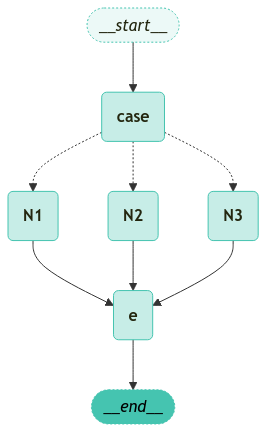

In [ ]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph0)

In [ ]:
graph0.invoke({'user_input' : '1번과 2번을 사용해서 이 문제를 풀어주세요'})

NotImplementedError: 